In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import scipy

from matplotlib.lines import Line2D

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
seed = sum(map(ord, "RL_PyMC"))
rng = np.random.default_rng(seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

In [4]:
def generate_data(rng, alpha, beta, n=100, p_r=None):
    if p_r is None:
        p_r = [0.4, 0.6]
    actions = np.zeros(n, dtype="int")
    rewards = np.zeros(n, dtype="int")
    Qs = np.zeros((n, 2))

    # Initialize Q table
    Q = np.array([0.5, 0.5])
    for i in range(n):
        # Apply the Softmax transformation
        exp_Q = np.exp(beta * Q)
        prob_a = exp_Q / np.sum(exp_Q)

        # Simulate choice and reward
        a = rng.choice([0, 1], p=prob_a)
        r = rng.random() < p_r[a]

        # Update Q table
        Q[a] = Q[a] + alpha * (r - Q[a])

        # Store values
        actions[i] = a
        rewards[i] = r
        Qs[i] = Q.copy()

    return actions, rewards, Qs

In [5]:
true_alpha = 0.5
true_beta = 5
n = 150
actions, rewards, Qs = generate_data(rng, true_alpha, true_beta, n)

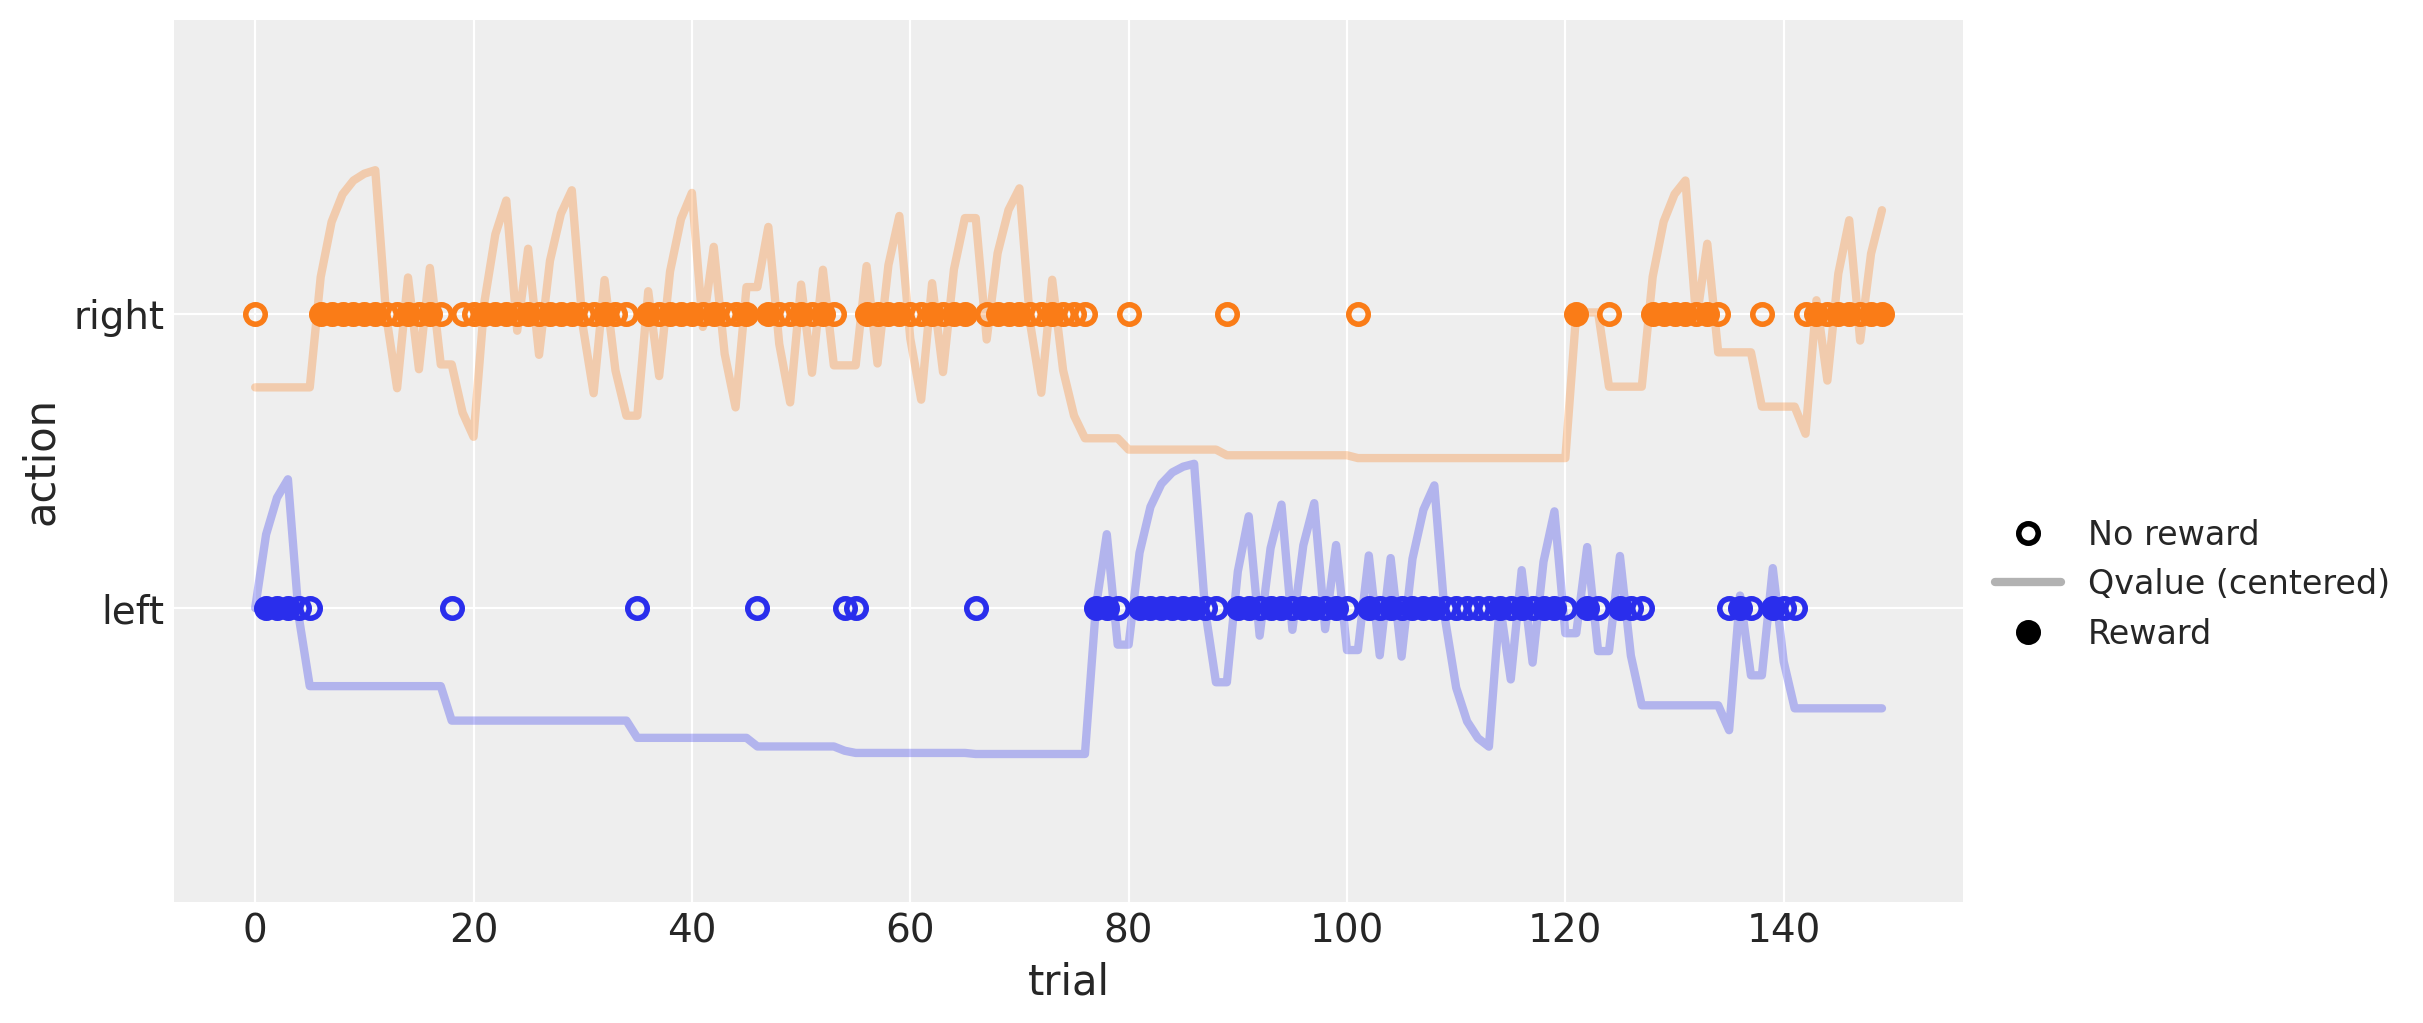

In [6]:
_, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(actions))

ax.plot(x, Qs[:, 0] - 0.5 + 0, c="C0", lw=3, alpha=0.3)
ax.plot(x, Qs[:, 1] - 0.5 + 1, c="C1", lw=3, alpha=0.3)

s = 7
lw = 2

cond = (actions == 0) & (rewards == 0)
ax.plot(x[cond], actions[cond], "o", ms=s, mfc="None", mec="C0", mew=lw)

cond = (actions == 0) & (rewards == 1)
ax.plot(x[cond], actions[cond], "o", ms=s, mfc="C0", mec="C0", mew=lw)

cond = (actions == 1) & (rewards == 0)
ax.plot(x[cond], actions[cond], "o", ms=s, mfc="None", mec="C1", mew=lw)

cond = (actions == 1) & (rewards == 1)
ax.plot(x[cond], actions[cond], "o", ms=s, mfc="C1", mec="C1", mew=lw)

ax.set_yticks([0, 1], ["left", "right"])
ax.set_ylim(-1, 2)
ax.set_ylabel("action")
ax.set_xlabel("trial")

reward_artist = Line2D([], [], c="k", ls="none", marker="o", ms=s, mew=lw, label="Reward")
no_reward_artist = Line2D(
    [], [], ls="none", marker="o", mfc="w", mec="k", ms=s, mew=lw, label="No reward"
)
Qvalue_artist = Line2D([], [], c="k", ls="-", lw=3, alpha=0.3, label="Qvalue (centered)")

ax.legend(handles=[no_reward_artist, Qvalue_artist, reward_artist], fontsize=12, loc=(1.01, 0.27));

In [34]:
def llik_td(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    actions, rewards = args

    # Initialize values
    Q = np.array([0.5, 0.5])
    logp_actions = np.zeros(len(actions))

    for t, (a, r) in enumerate(zip(actions, rewards)):
        # Apply the softmax transformation
        Q_ = Q * beta
        logp_action = Q_ - scipy.special.logsumexp(Q_)

        # Store the log probability of the observed action
        logp_actions[t] = logp_action[a]

        # Update the Q values for the next trial
        Q[a] = Q[a] + alpha * (r - Q[a])

    # Return the negative log likelihood of all observed actions
    return -np.sum(logp_actions[1:])

In [35]:
llik_td([true_alpha, true_beta], *(actions, rewards))

47.41893609720702

In [14]:
x0 = [true_alpha, true_beta]
result = scipy.optimize.minimize(llik_td, x0, args=(actions, rewards), method="BFGS")
print(result)
print("")
print(f"MLE: alpha = {result.x[0]:.2f} (true value = {true_alpha})")
print(f"MLE: beta = {result.x[1]:.2f} (true value = {true_beta})")

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 47.05081454110274
        x: [ 5.047e-01  5.707e+00]
      nit: 7
      jac: [-9.537e-07  4.768e-07]
 hess_inv: [[ 7.333e-03 -2.421e-02]
            [-2.421e-02  8.693e-01]]
     nfev: 30
     njev: 10

MLE: alpha = 0.50 (true value = 0.5)
MLE: beta = 5.71 (true value = 5)


In [15]:
def llik_td_vectorized(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    actions, rewards = args

    # Create a list with the Q values of each trial
    Qs = np.ones((n, 2), dtype="float64")
    Qs[0] = 0.5
    for t, (a, r) in enumerate(
        zip(actions[:-1], rewards[:-1])
    ):  # The last Q values were never used, so there is no need to compute them
        Qs[t + 1, a] = Qs[t, a] + alpha * (r - Qs[t, a])
        Qs[t + 1, 1 - a] = Qs[t, 1 - a]

    # Apply the softmax transformation in a vectorized way
    Qs_ = Qs * beta
    logp_actions = Qs_ - scipy.special.logsumexp(Qs_, axis=1)[:, None]

    # Return the logp_actions for the observed actions
    logp_actions = logp_actions[np.arange(len(actions)), actions]
    return -np.sum(logp_actions[1:])

In [17]:
llik_td_vectorized([true_alpha, true_beta], *(actions, rewards))

47.41893609720702

In [18]:
%timeit llik_td([true_alpha, true_beta], *(actions, rewards))

1.43 ms ± 82.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [19]:
%timeit llik_td_vectorized([true_alpha, true_beta], *(actions, rewards))

103 μs ± 2.59 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [20]:
def update_Q(action, reward, Qs, alpha):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by pytensor.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the pytensor.scan fn argument:
        fn=lamba action, reward, Qs, alpha: pt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """

    Qs = pt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    return Qs

In [36]:
# Transform the variables into appropriate PyTensor objects
rewards_ = pt.as_tensor_variable(rewards, dtype="int32")
actions_ = pt.as_tensor_variable(actions, dtype="int32")

alpha = pt.scalar("alpha")
beta = pt.scalar("beta")

# Initialize the Q table
Qs = 0.5 * pt.ones((2,), dtype="float64")

# Compute the Q values for each trial
Qs, _ = pytensor.scan(
    fn=update_Q, sequences=[actions_, rewards_], outputs_info=[Qs], non_sequences=[alpha]
)

# Apply the softmax transformation
Qs = Qs * beta
logp_actions = Qs - pt.logsumexp(Qs, axis=1, keepdims=True)

# Calculate the negative log likelihod of the observed actions
logp_actions = logp_actions[pt.arange(actions_.shape[0] - 1), actions_[1:]]
neg_loglike = -pt.sum(logp_actions)

In [37]:
pytensor_llik_td = pytensor.function(
    inputs=[alpha, beta], outputs=neg_loglike, on_unused_input="ignore"
)
result = pytensor_llik_td(true_alpha, true_beta)
float(result)

47.418936097206995

In [23]:
def pytensor_llik_td(alpha, beta, actions, rewards):
    rewards = pt.as_tensor_variable(rewards, dtype="int32")
    actions = pt.as_tensor_variable(actions, dtype="int32")

    # Compute the Qs values
    Qs = 0.5 * pt.ones((2,), dtype="float64")
    Qs, updates = pytensor.scan(
        fn=update_Q, sequences=[actions, rewards], outputs_info=[Qs], non_sequences=[alpha]
    )

    # Apply the sotfmax transformation
    Qs = Qs[:-1] * beta
    logp_actions = Qs - pt.logsumexp(Qs, axis=1, keepdims=True)

    # Calculate the log likelihood of the observed actions
    logp_actions = logp_actions[pt.arange(actions.shape[0] - 1), actions[1:]]
    return pt.sum(logp_actions)  # PyMC expects the standard log-likelihood

In [24]:
with pm.Model() as m:
    alpha = pm.Beta(name="alpha", alpha=1, beta=1)
    beta = pm.HalfNormal(name="beta", sigma=10)

    like = pm.Potential(name="like", var=pytensor_llik_td(alpha, beta, actions, rewards))

    tr = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


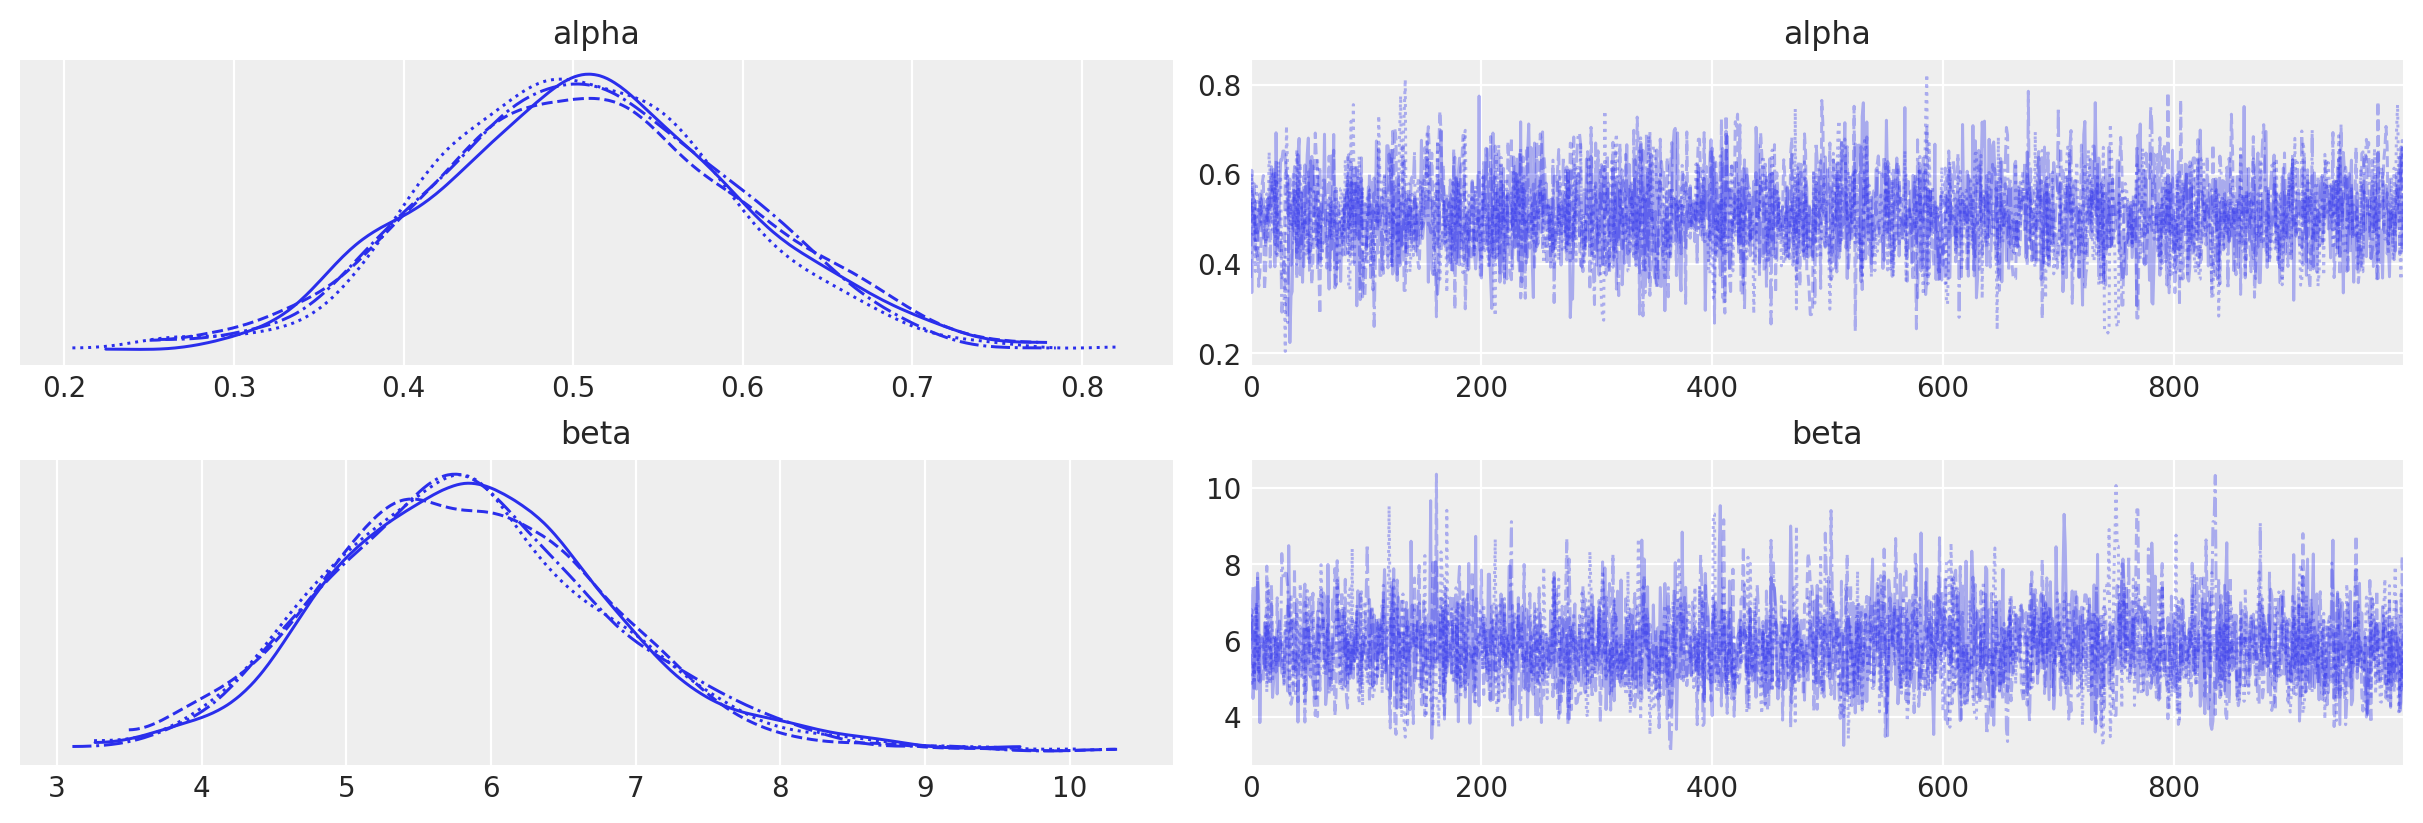

In [25]:
az.plot_trace(data=tr);

In [26]:
def right_action_probs(alpha, beta, actions, rewards):
    rewards = pt.as_tensor_variable(rewards, dtype="int32")
    actions = pt.as_tensor_variable(actions, dtype="int32")

    # Compute the Qs values
    Qs = 0.5 * pt.ones((2,), dtype="float64")
    Qs, updates = pytensor.scan(
        fn=update_Q, sequences=[actions, rewards], outputs_info=[Qs], non_sequences=[alpha]
    )

    # Apply the sotfmax transformation
    Qs = Qs[:-1] * beta
    logp_actions = Qs - pt.logsumexp(Qs, axis=1, keepdims=True)

    # Return the probabilities for the right action, in the original scale
    return pt.exp(logp_actions[:, 1])

In [27]:
with pm.Model() as m_alt:
    alpha = pm.Beta(name="alpha", alpha=1, beta=1)
    beta = pm.HalfNormal(name="beta", sigma=10)

    action_probs = right_action_probs(alpha, beta, actions, rewards)
    like = pm.Bernoulli(name="like", p=action_probs, observed=actions[1:])

    tr_alt = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


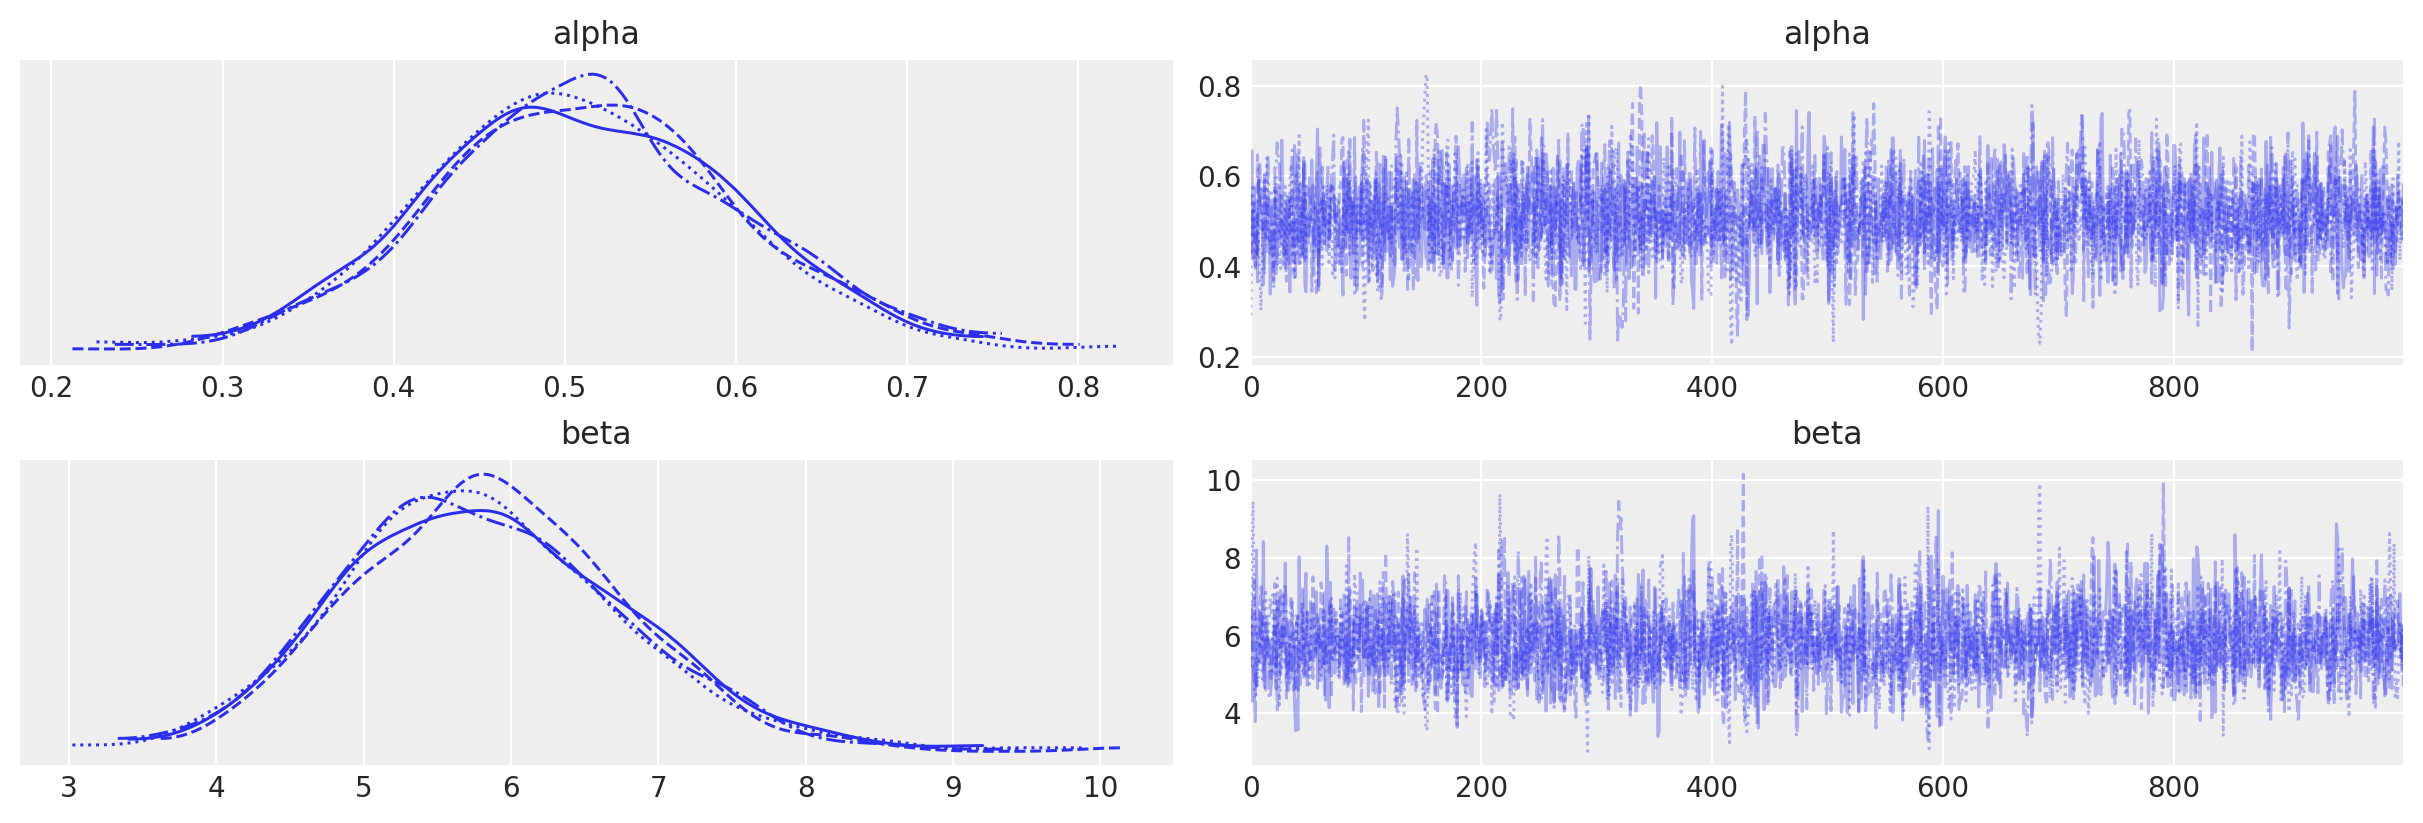

In [28]:
az.plot_trace(data=tr_alt);

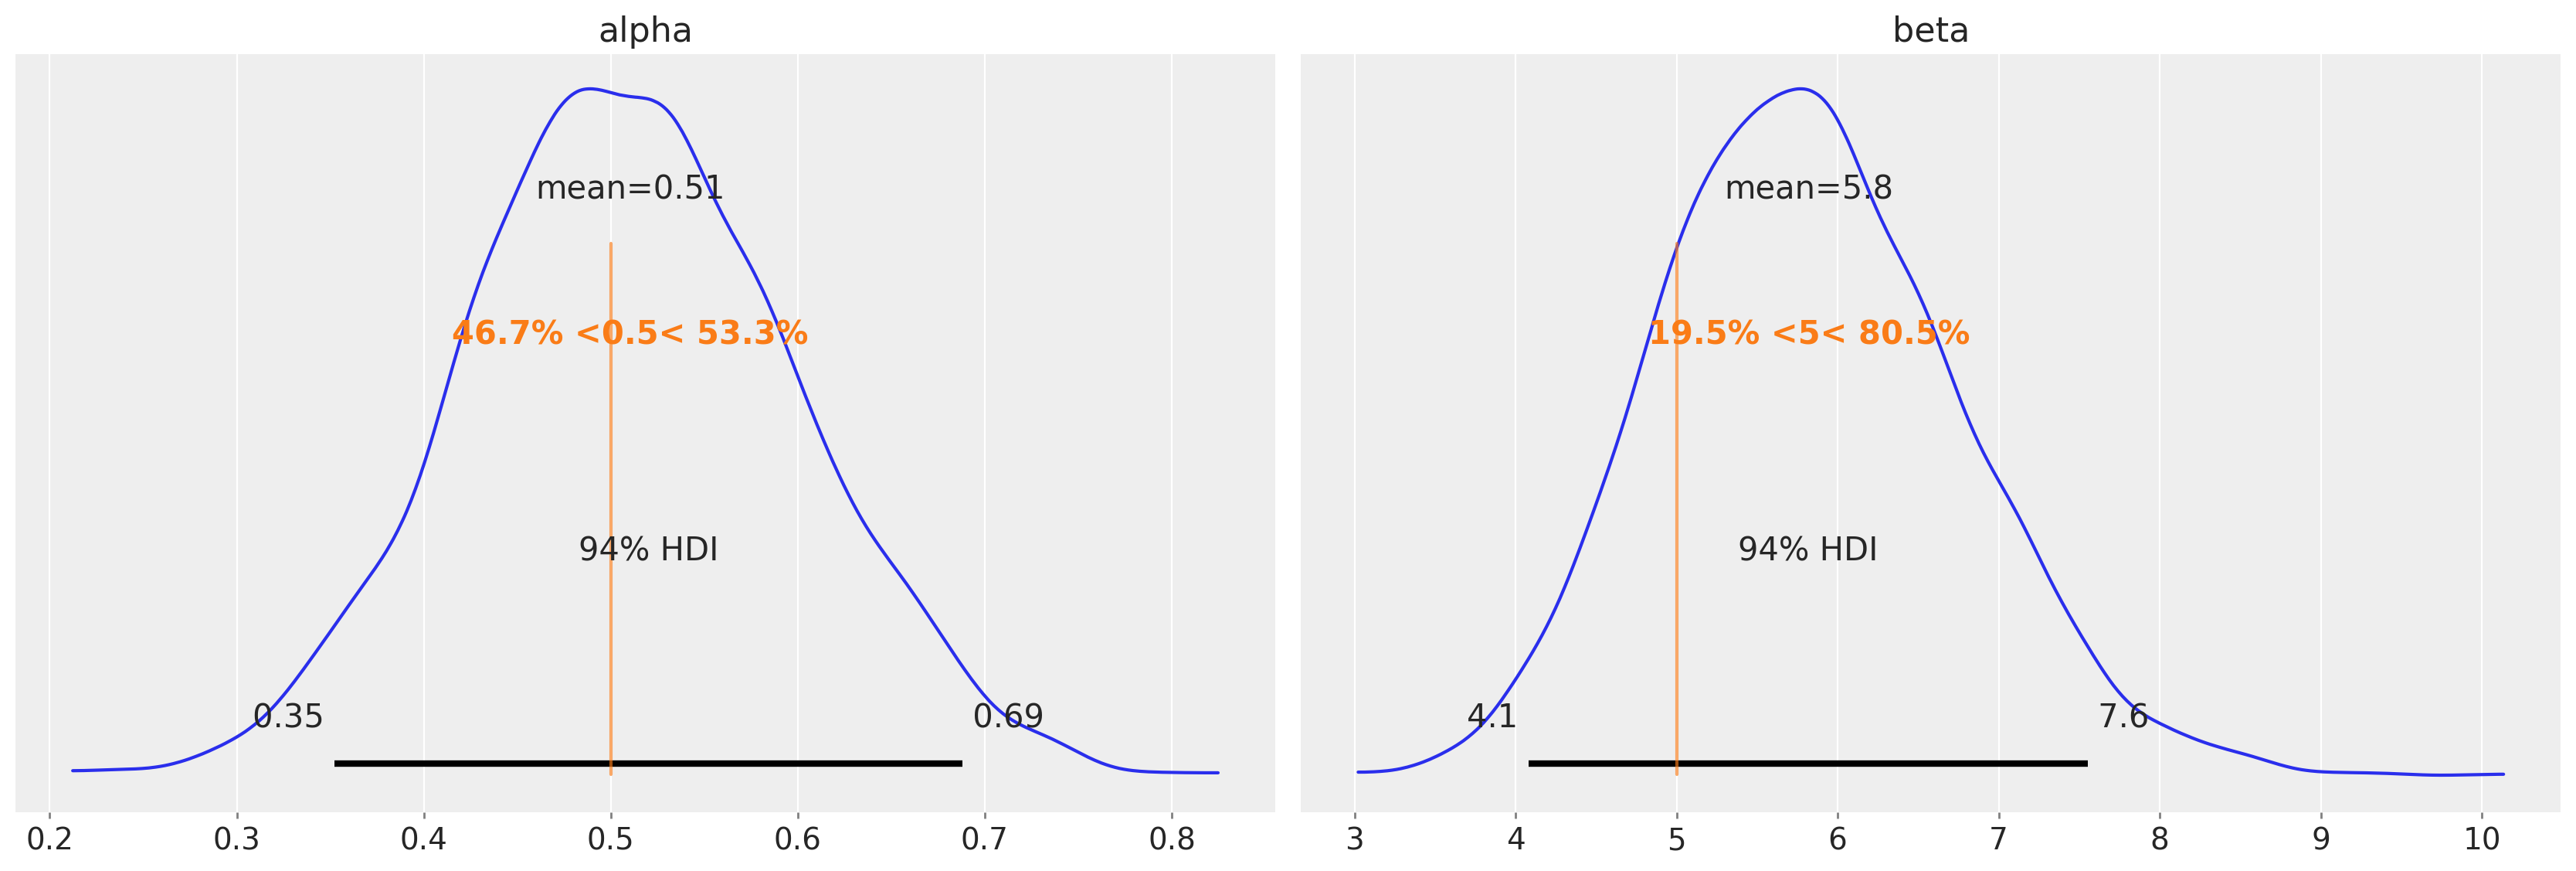

In [29]:
az.plot_posterior(data=tr_alt, ref_val=[true_alpha, true_beta]);